In [3]:
!pip install numpy scipy pandas mne scikit-learn tensorflow matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
pip install --upgrade pip

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import os
import pickle

# configutation
DATA_PATH = r"C:\Users\Sameera\.cache\kagglehub\datasets\manh123df\deap-dataset\versions\1\deap-dataset\data_preprocessed_python"

VALENCE_THRESHOLD = 5.0 # High vs low valance
TIME_WINDOW = 60 # Duration per trail in seconds
SAMPLING_RATE = 128 # Hz

# Load all subjects' data
subject_files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith('.dat')])

all_data = []
all_labels = []

for file_name in subject_files:
    file_path = os.path.join(DATA_PATH, file_name)
    print(f"Loading: {file_name}")

    # Each .dat file is a pickled Python dictionary
    with open(file_path, 'rb') as f:
        subject_data = pickle.load(f, encoding='latin1')

    # Extract EEG data (first 32 channles)
    eeg_data = subject_data['data'][:, 0:32, :] # shape: (40, 32, 8064)

    # Extract labels (valence, arousal, dominance, liking)
    labels = subject_data['labels']

    # Binary valence labels (0 = Low, 1 = High)
    valence_labels = (labels[:, 0] >= VALENCE_THRESHOLD).astype(int)

    all_data.append(eeg_data)
    all_labels.append(valence_labels)

# combine all subjects
X = np.concatenate(all_data, axis = 0) # shape : (32 subjects * 40 trials, 32, 8064)
Y = np.concatenate(all_labels, axis = 0) # shape : (32 subjects * 40 trails)

print("\nData Loaded Successfully!")
print(f"Total EEG trials (X) : {X.shape}")
print(f"Total Labels (Y) : {Y.shape}")

Loading: s01.dat
Loading: s02.dat
Loading: s03.dat
Loading: s04.dat
Loading: s05.dat
Loading: s06.dat
Loading: s07.dat
Loading: s08.dat
Loading: s09.dat
Loading: s10.dat
Loading: s11.dat
Loading: s12.dat
Loading: s13.dat
Loading: s14.dat
Loading: s15.dat
Loading: s16.dat
Loading: s17.dat
Loading: s18.dat
Loading: s19.dat
Loading: s20.dat
Loading: s21.dat
Loading: s22.dat
Loading: s23.dat
Loading: s24.dat
Loading: s25.dat
Loading: s26.dat
Loading: s27.dat
Loading: s28.dat
Loading: s29.dat
Loading: s30.dat
Loading: s31.dat
Loading: s32.dat

Data Loaded Successfully!
Total EEG trials (X) : (1280, 32, 8064)
Total Labels (Y) : (1280,)


In [26]:
# Feature Engineering

# Raw data X is too high-dimensional (8064 time points) for direct training. We must extract frequency-domain features, 
# such as Power Spectral Density (PSD) across standard EEG bands, to create a concise "feature image" for the CNN. 
# This is standard practice in EEG emotion recognition

# Extract PSD Features

from scipy.signal import welch

def extract_psd_features(eeg_data, fs):
    """
    Extracts Power Spectral Density (PSD) features from EEG data for standard frequency bands.
    Input shape: (Trials, Channels, Time Points)
    Output shape: (Trials, Channels, Bands)
    """

    # EEG Frequency Bands in Hz: Delta (0.5–4), Theta (4–8), Alpha (8–13), Beta (13–30), Gamma (30–48)
    bands = {'delta':[0.5,4], 'theta':[4,8], 'alpha':[8,13], 'beta':[13,30], 'gamma':[30,48]}

    num_trials, num_channels, num_timepoints = eeg_data.shape
    num_bands = len(bands)

    # Feature matrix : (Trails, Channels, Bands)
    X_features = np.zeros((num_trials, num_channels, num_bands))

    # Short time window (2 seconds) used for PSD calculation
    nperseg = int(fs * 2)

    for i in range(num_trials):
        for ch in range(num_channels):
            # Compute PSD using Welch's method (robust aginst noise)
            freqs, psd_values = welch(eeg_data[i, ch, :], fs=fs, nperseg=nperseg, axis=-1)

            for b_idx, (name, (low, high)) in enumerate(bands.items()):
                # find indices corrresponding to the frequency band
                idx_band = np.logical_and(freqs >= low, freqs <= high)

                # calculate the mean power within the band
                if np.any(idx_band):
                    band_power = np.mean(psd_values[idx_band])
                    X_features[i, ch, b_idx] = band_power


    return X_features

# Extract features from the loaded data
X_cnn_input = extract_psd_features(X, SAMPLING_RATE)

print(f"CNN Feature Input Shape (Trials, Channels, Bands): {X_cnn_input.shape}")

CNN Feature Input Shape (Trials, Channels, Bands): (1280, 32, 5)


In [28]:
# Split, Normalize, and Reshape

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Set a seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Split into training (80%) and test(20%) sets
X_train_full, X_test, Y_train_full, Y_test = train_test_split(
    X_cnn_input, Y, test_size=0.2, random_state=42, stratify=Y
)

# 2. Split Training into Training (90%) and Validation (10%) sets
# This results in an overall split of 72% Train, 8% Validation, 20% Test)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.1, random_state=42, stratify=Y_train_full
)

# 3. Normalize Features (Fit scaler ONLY on training data to prevent data leakage)
scaler = StandardScaler()
# Reshape for scaler: (Trials * H * W, 1) to fit_transform
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Fit the scalaer on the flattened training data
scaler.fit(X_train_flat)

# Transform all set back to the correct 3D shape
X_train_norm = scaler.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val_norm = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# 4. Reshape for CNN Input and One-Hot Encode Labels
# CNN input requires a channel dimension: (Batch, Height, Width, Channels)
X_train_final = X_train_norm[..., np.newaxis]
X_val_final = X_val_norm[..., np.newaxis]
X_test_final = X_test_norm[..., np.newaxis]

# One-Hot Encode Labels (0 -> [1, 0]; 1 -> [0, 1])
Y_train_cat = to_categorical(Y_train, num_classes=2)
Y_val_cat = to_categorical(Y_val, num_classes=2)
Y_test_cat = to_categorical(Y_test, num_classes=2)

print("Data Split and Normalized.")
print(f"Train Input Shape: {X_train_final.shape}")
print(f"Validation Input Shape: {X_val_final.shape}")
print(f"Test Input Shape: {X_test_final.shape}")

Data Split and Normalized.
Train Input Shape: (921, 32, 5, 1)
Validation Input Shape: (103, 32, 5, 1)
Test Input Shape: (256, 32, 5, 1)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    """Defines a simple 2D CNN model for spatio-spectral EEG features."""
    model = Sequential([
        # 1. Input Layer and First Conv Block
        # Learns 32 filters (feature maps) over the 32x5 input "image"
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2, 1)), # Pool across channels, not bands
        Dropout(0.3), 

        # 2. Second Conv Block
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(0.3),

        # 3. Classifier Head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        # Output layer: 2 classes (High/Low Valence)
        Dense(2, activation='softmax') # This is your base prediction output (y_base)
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model
input_shape = X_train_final.shape[1:] 
cnn_model = create_cnn_model(input_shape)
print("\n--- Baseline CNN Model Summary ---")
cnn_model.summary()

# --- Training ---
EPOCHS = 50
BATCH_SIZE = 32

print("\nStarting Model Training...")
history = cnn_model.fit(
    X_train_final,
    Y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_final, Y_val_cat),
    verbose=1
)
print("Training Complete.")



--- Baseline CNN Model Summary ---


C:\Users\Sameera\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 5, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 5, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 346,882 (1.32 MB)

 Trainable params: 346,882 (1.32 MB)

 Non-trainable params: 0 (0.00 B)


Starting Model Training...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7611 - loss: 0.5857 - val_accuracy: 0.7767 - val_loss: 0.5571
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7785 - loss: 0.5445 - val_accuracy: 0.7767 - val_loss: 0.5468
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7774 - loss: 0.5264 - val_accuracy: 0.7767 - val_loss: 0.5342
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7763 - loss: 0.5271 - val_accuracy: 0.7767 - val_loss: 0.5310
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.5269 - val_accuracy: 0.7864 - val_loss: 0.5362
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7720 - loss: 0.5214 - val_accuracy: 0.7767 - val_loss: 0.5289
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.5254 - val_accuracy: 0.7767 - val_loss: 0.5343
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7807 - loss: 0.5146 - va

In [31]:
!pip install seaborn


--- Evaluating on Test Set ---
Test Loss: 0.5901
Test Accuracy: 75.78%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Classification Report (High/Low Valence) ---
                  precision    recall  f1-score   support

 Low Valence (0)       0.78      0.95      0.86       199
High Valence (1)       0.33      0.09      0.14        57

        accuracy                           0.76       256
       macro avg       0.56      0.52      0.50       256
    weighted avg       0.68      0.76      0.70       256



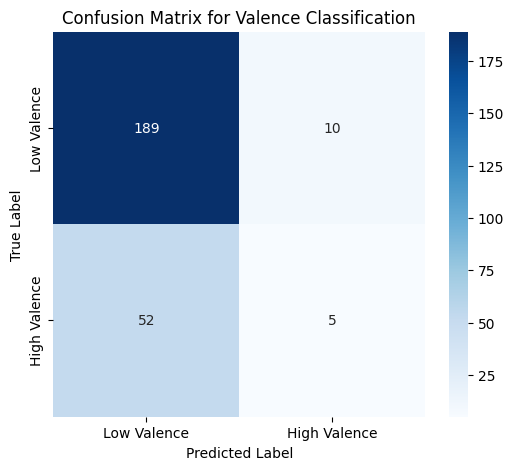

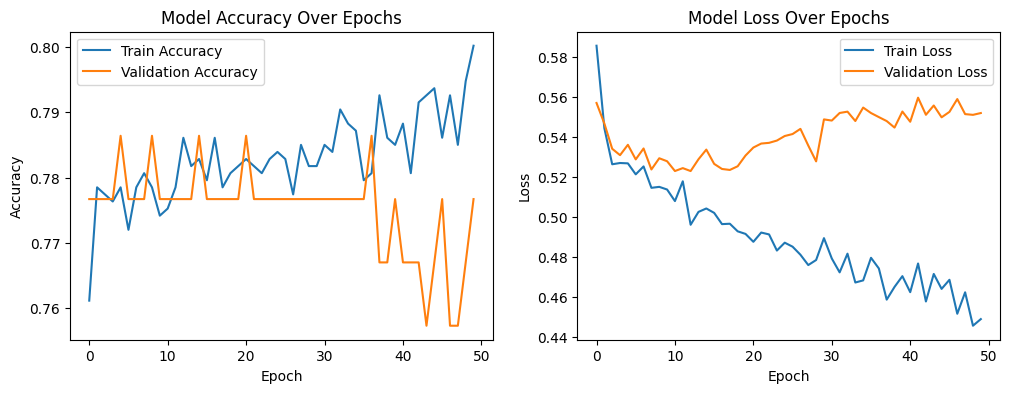

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Evaluate on the unseen Test Set
print("\n--- Evaluating on Test Set ---")
loss, accuracy = cnn_model.evaluate(X_test_final, Y_test_cat, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 2. Get predictions and classification report
Y_pred_cat = cnn_model.predict(X_test_final)
Y_pred = np.argmax(Y_pred_cat, axis=1) # Convert one-hot back to class labels

print("\n--- Classification Report (High/Low Valence) ---")
print(classification_report(Y_test, Y_pred, target_names=['Low Valence (0)', 'High Valence (1)']))

# 3. Visualize Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Valence', 'High Valence'], 
            yticklabels=['Low Valence', 'High Valence'])
plt.title('Confusion Matrix for Valence Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()